# Machine Learning
## Assignment - 1
written by : Jameel Ahmed Syed
email : j.syed@innopolis.university

# Classification Task

#### 1. Import All the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso, Ridge
from pandas_profiling import ProfileReport
from category_encoders import OneHotEncoder, BinaryEncoder, SumEncoder, PolynomialEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#### 2. Read the train and test data from csv files

In [2]:
stream_quality = pd.read_csv("stream_quality_data/train_data.csv")
stream_quality_test = pd.read_csv("stream_quality_data/test_data.csv")

#### 3. Profile Report for the training and testing data

In [3]:
#profile_1 = ProfileReport(stream_quality)
#profile_1.to_file("Stream-Quality-Profile-Report.html")
#profile_2 = ProfileReport(stream_quality_test)
#profile_2.to_file("Stream-Quality-Test-Profile-Report.html")

In [4]:
%matplotlib inline
#profile_1.to_notebook_iframe()

#### 4. Exploring data

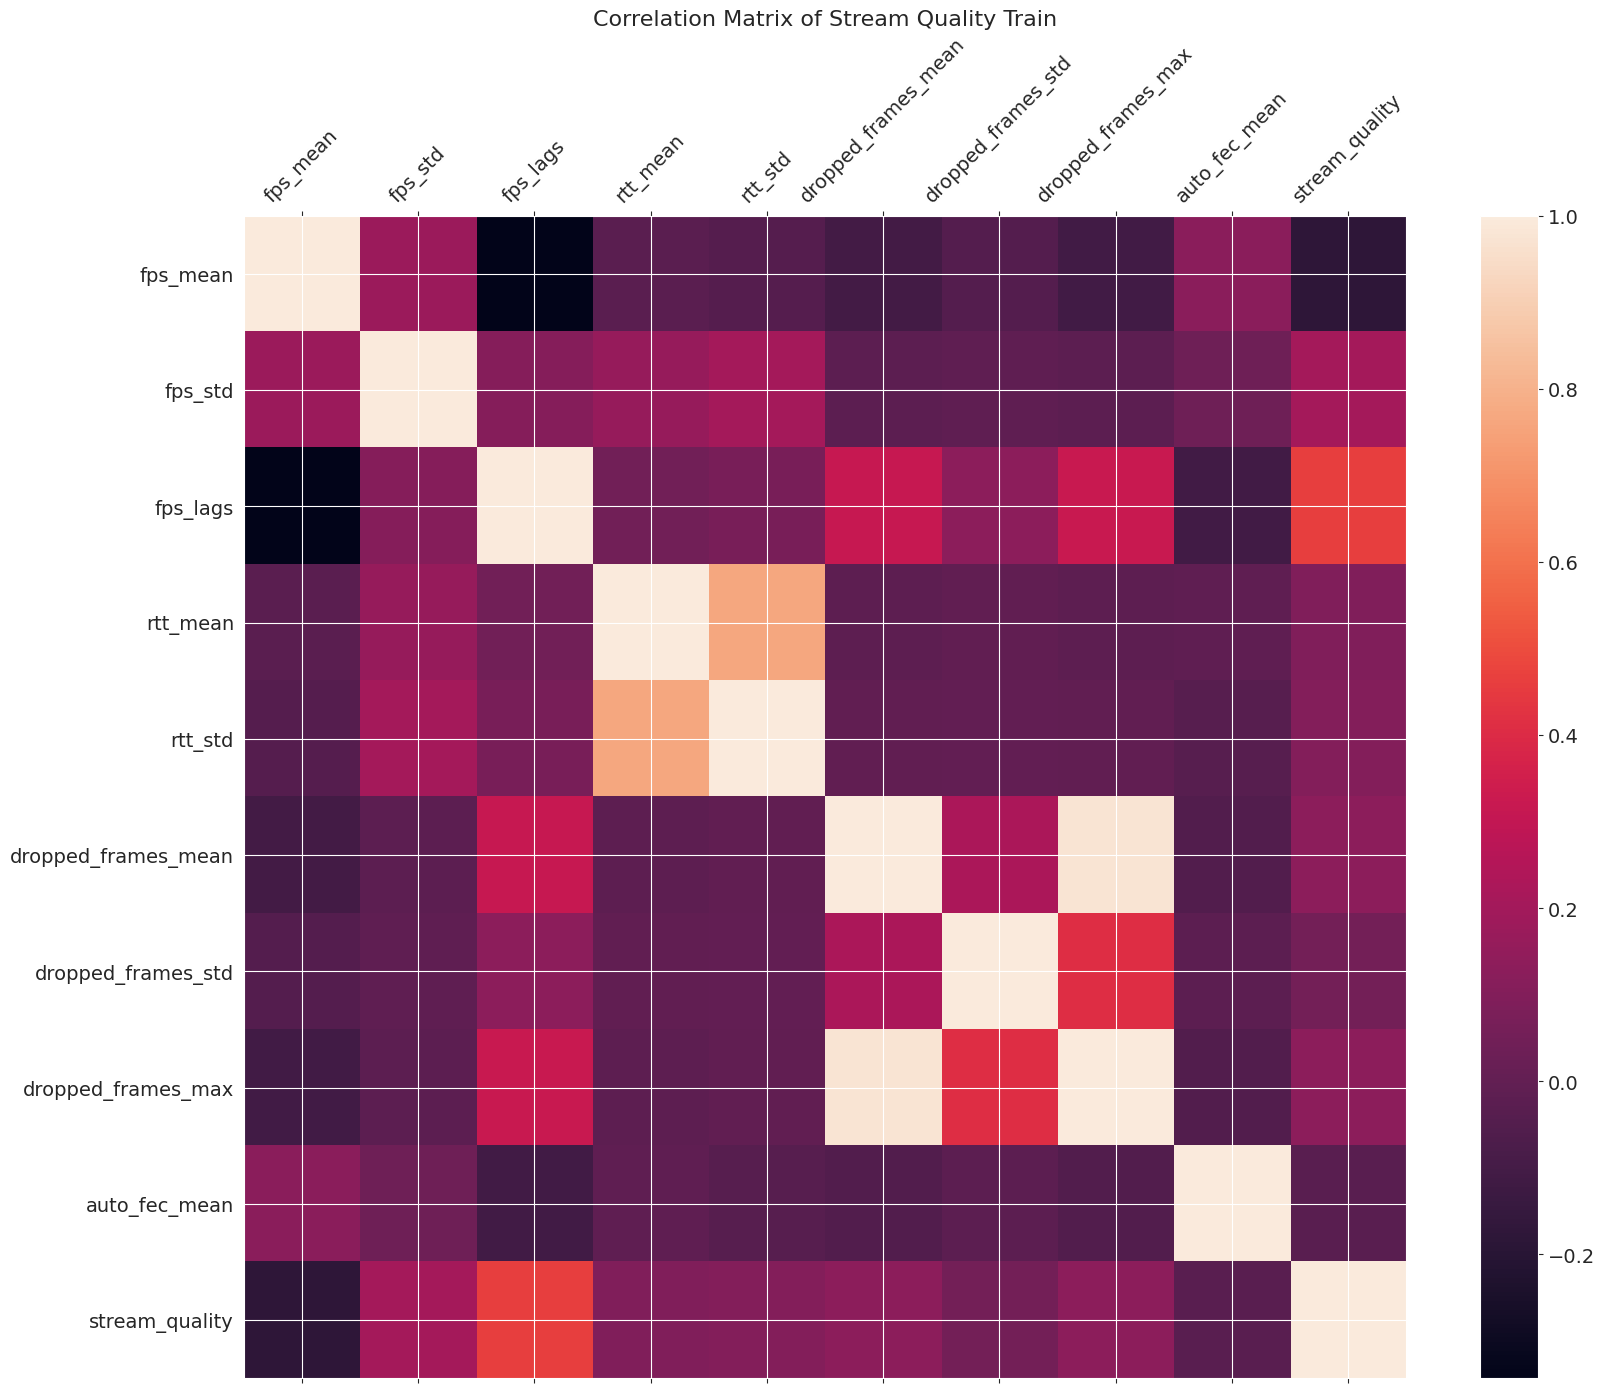

In [5]:
# Plot the correlation Matrix of the Stream Quality train
f = plt.figure(figsize=(19, 15))
plt.matshow(stream_quality.corr(), fignum=f.number)
plt.xticks(range(stream_quality.select_dtypes(['number']).shape[1]), stream_quality.select_dtypes(['number']).columns, fontsize=14,
               rotation=45)
plt.yticks(range(stream_quality.select_dtypes(['number']).shape[1]), stream_quality.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of Stream Quality Train', fontsize=16)
plt.show()

In [6]:
stream_quality.describe()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_fec_mean,stream_quality
count,406572.000000,406572.000000,406572.000000,406572.000000,406572.000000,4.065720e+05,4.065720e+05,4.065720e+05,406572.000000,406572.000000
mean,34.497561,2.285486,0.183151,54.314400,19.525019,1.730432e+06,1.378279e+05,1.893339e+06,51.413536,0.068460
std,11.625494,3.708531,1.099384,133.872062,156.364337,4.930091e+07,9.229776e+06,5.241003e+07,34.836045,0.252534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,28.300000,0.316228,0.000000,14.100000,0.699206,0.000000e+00,0.000000e+00,0.000000e+00,50.000000,0.000000
50%,30.000000,0.994429,0.000000,32.300000,1.490712,0.000000e+00,0.000000e+00,0.000000e+00,50.000000,0.000000
75%,43.000000,2.590581,0.000000,57.100000,5.334375,0.000000e+00,0.000000e+00,0.000000e+00,50.000000,0.000000
max,127.100000,312.540842,10.000000,12898.400000,40721.933293,2.097289e+09,9.963751e+08,2.097289e+09,250.000000,1.000000


In [7]:
stream_quality_test.describe()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_fec_mean,stream_quality
count,243596.000000,243596.000000,243596.000000,243596.000000,243596.000000,2.435960e+05,243596.000000,2.435960e+05,243596.000000,243596.000000
mean,34.655252,2.261398,0.103253,55.273762,20.683917,3.153827e+04,1.573091,3.154188e+04,49.408948,0.064426
std,10.986547,3.554645,0.615878,163.872966,146.242876,5.882144e+06,70.320152,5.882144e+06,35.649026,0.245511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,28.600000,0.316228,0.000000,14.600000,0.707107,0.000000e+00,0.000000,0.000000e+00,50.000000,0.000000
50%,30.000000,0.994429,0.000000,30.600000,1.699673,0.000000e+00,0.000000,0.000000e+00,50.000000,0.000000
75%,42.500000,2.547330,0.000000,59.300000,6.624030,0.000000e+00,0.000000,0.000000e+00,50.000000,0.000000
max,84.600000,150.766044,10.000000,13456.800000,9561.738301,1.097304e+09,34537.342512,1.097304e+09,250.000000,1.000000


#### 5. Detecting and Removing the Outliers

In [8]:
def remove_outliers(x, coln):
    """Detects and removes the outliers from the dataframe
    :param x: Dataframe
    :param coln: Feature/Column name from the dataframe"""
    q1 = x[coln].quantile(0.25)
    q3 = x[coln].quantile(0.75)
    iqr = q3-q1     # Inter quartile range
    thresh_low = q1-1.5*iqr
    thresh_high = q3+1.5*iqr
    df_out = x.loc[(x[coln] > thresh_low) & (x[coln] < thresh_high)]
    return df_out

In [9]:
# Remove Outliers from Train set

features = list()
for col in stream_quality.drop(['stream_quality'], axis=1).columns:
    features.append(col)
print("All the features in training dataframe : \n", features)

print("\nDataframe shape before removing outliers: \n", stream_quality.shape)
stream_quality = remove_outliers(stream_quality, features[1])   # removes fps_std outliers
stream_quality = remove_outliers(stream_quality, features[3])   # removes rtt_mean outliers
stream_quality = remove_outliers(stream_quality, features[4])   # removes rtt_std outliers
print("\nDataframe shape after removing outliers: \n", stream_quality.shape)


All the features in training dataframe : 
 ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']

Dataframe shape before removing outliers: 
 (406572, 12)

Dataframe shape after removing outliers: 
 (290582, 12)


In [10]:
# Remove Outliers from Test set
features = list()
for col in stream_quality_test.drop(['stream_quality'], axis=1).columns:
    features.append(col)
print("All the features in stream quality test dataframe : ", features)

print("stream quality test shape before removing outliers: ", stream_quality_test.shape)
stream_quality_test = remove_outliers(stream_quality_test, features[1])  # removes fps_std outliers
stream_quality_test = remove_outliers(stream_quality_test, features[3])  # removes rtt_mean outliers
stream_quality_test = remove_outliers(stream_quality_test, features[4])  # removes rtt_std outliers
print("stream quality test shape after removing outliers: ", stream_quality_test.shape)


All the features in stream quality test dataframe :  ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']
stream quality test shape before removing outliers:  (243596, 12)
stream quality test shape after removing outliers:  (177815, 12)


#### 6. Splitting the targets from the train and test dataframe

In [11]:
# Splitting the 'stream_quality' column from the train_data
# and storing it in y_train, y_test respectively
# We Get the x_train, y_train and x_test, y_test data

x_train = stream_quality.drop(['stream_quality'], axis=1)
y_train = stream_quality.loc[:, 'stream_quality']
x_test = stream_quality_test.drop(columns=['stream_quality'])  # Can use the columns arg to avoid writing axis = 1
y_test = stream_quality_test.loc[:, 'stream_quality']

In [12]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(290582, 11) (290582,) (177815, 11) (177815,)


#### 7. Data Preprocessing (Encoding, Imputing, Feature Selection, Scaling...etc)

In [13]:
def encode_one_hot(x):
    """Encodes the Dataframe with the OneHotEncoder
    :param x: X Dataframe which needs to be Encoded, Fitted and Transformed"""
    category_features = x.select_dtypes(include=['object']).columns.tolist()
    print("\nCategorical Features : ", category_features)
    encoder = OneHotEncoder(cols=category_features)
    encoder.fit(x)
    x = encoder.transform(x)
    # print("\nEncoded bit rate x_train : \n", x)
    return x

def impute_simple(x, strategy='mean'):
    """Imputes the Dataframe with the SimpleImputer
    :param x: X Dataframe which needs to be Imputed, Fitted and Transformed
    :param strategy: The strategy by which the dataframe needs to be imputed"""

    imputer = SimpleImputer(strategy='mean')
    imputer.fit(x)
    x = pd.DataFrame(imputer.transform(x), columns=x.columns)
    # print("\nImputed Bit Rate : \n", x)
    return x

def scale_std(x):
    """Scales the Dataframe with the RobustScaler
    :param x: X Dataframe which needs to be Scaled, Fitted and Transformed"""

    scaler = RobustScaler()
    scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x), columns=x.columns)
    # print("\nScaled Bit Rate : \n", x)
    return x

def data_preprocessing(x):
    """Data preprocessing - Encoding, Imputing, Feature Selection, Scaling of the Dataframe
    :param x: X Dataframe which needs to be Encoded, Imputed,
     Scaled, Fitted and Transformed"""

    # Encoding the data with the One Hot Encoder x_train
    x = encode_one_hot(x)

    # Imputing the data with the mean x_train
    x = impute_simple(x, strategy='mean')

    # Feature Selection new technique
    print("Shape of dataframe before Feature Selection : ", x.shape)
    x = x.replace(0, np.nan)
    x = x.dropna(axis=1, thresh=0.05*len(x))
    print("Removed columns with 95% zeros")
    print("Shape of dataframe after Feature Selection : ", x.shape)
    x = x.replace(np.nan, 0)

    # Scaling the data with Robust Scaler x_train
    x = scale_std(x)
    return x

In [14]:
# Data preprocessing - Encoding, Imputing, Feature Selection, Scaling
print("\nData-preprocessing of x_train:", end="")
x_train = data_preprocessing(x_train)
print("\nData-preprocessing of x_test:", end="")
x_test = data_preprocessing(x_test)


Data-preprocessing of x_train:
Categorical Features :  ['auto_bitrate_state', 'auto_fec_state']
Shape of dataframe before Feature Selection :  (290582, 14)
Removed columns with 95% zeros
Shape of dataframe after Feature Selection :  (290582, 9)

Data-preprocessing of x_test:
Categorical Features :  ['auto_bitrate_state', 'auto_fec_state']
Shape of dataframe before Feature Selection :  (177815, 14)
Removed columns with 95% zeros
Shape of dataframe after Feature Selection :  (177815, 9)


In [15]:
x_train.head()

,fps_mean,fps_std,rtt_mean,rtt_std,auto_bitrate_state_1,auto_bitrate_state_2,auto_fec_state_1,auto_fec_state_2,auto_fec_mean
0,-0.402878,-0.101139,2.129450,3.182469,0.0,0.0,0.0,0.0,0.0
1,0.000000,-0.375000,1.834951,-0.595164,0.0,0.0,0.0,0.0,0.0
2,0.000000,-0.375000,1.834951,-0.595164,0.0,0.0,0.0,0.0,0.0
3,0.000000,-0.375000,1.834951,-0.595164,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.375000,1.834951,-0.595164,0.0,0.0,0.0,0.0,0.0


In [16]:
x_test.head()

,fps_mean,fps_std,rtt_mean,rtt_std,auto_bitrate_state_1,auto_bitrate_state_3,auto_fec_state_1,auto_fec_state_2,auto_fec_mean
0,-0.008197,-0.216741,0.984424,-0.098810,0.0,0.0,0.0,0.0,0.0
1,0.000000,-0.395706,0.984424,-0.098810,0.0,0.0,0.0,0.0,0.0
2,0.000000,-0.395706,1.015576,0.975976,0.0,0.0,0.0,0.0,0.0
3,-0.008197,-0.216741,1.090343,1.568624,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.395706,0.975078,0.042026,0.0,0.0,0.0,0.0,0.0


Features Selected from the data preprocessing are:

In [17]:
# Selected Features after data preprocessing stage
selected_features = list()
for col in x_train.columns:
    selected_features.append(col)
print("\nSelected Features : ", selected_features)


Selected Features :  ['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'auto_bitrate_state_1', 'auto_bitrate_state_2', 'auto_fec_state_1', 'auto_fec_state_2', 'auto_fec_mean']


In [18]:
def pair_plot(x, suptitle_label='Pair Plot of X data'):
    """Plots a Pair Plot from a Dataframe
    :param x: X Dataframe which needs to be pair-plotted
    :param suptitle_label: It's a label for the plot"""

    plt.figure()
    sns.pairplot(pd.DataFrame(x))
    plt.suptitle(suptitle_label)
    plt.show()
    return None

<Figure size 640x480 with 0 Axes>

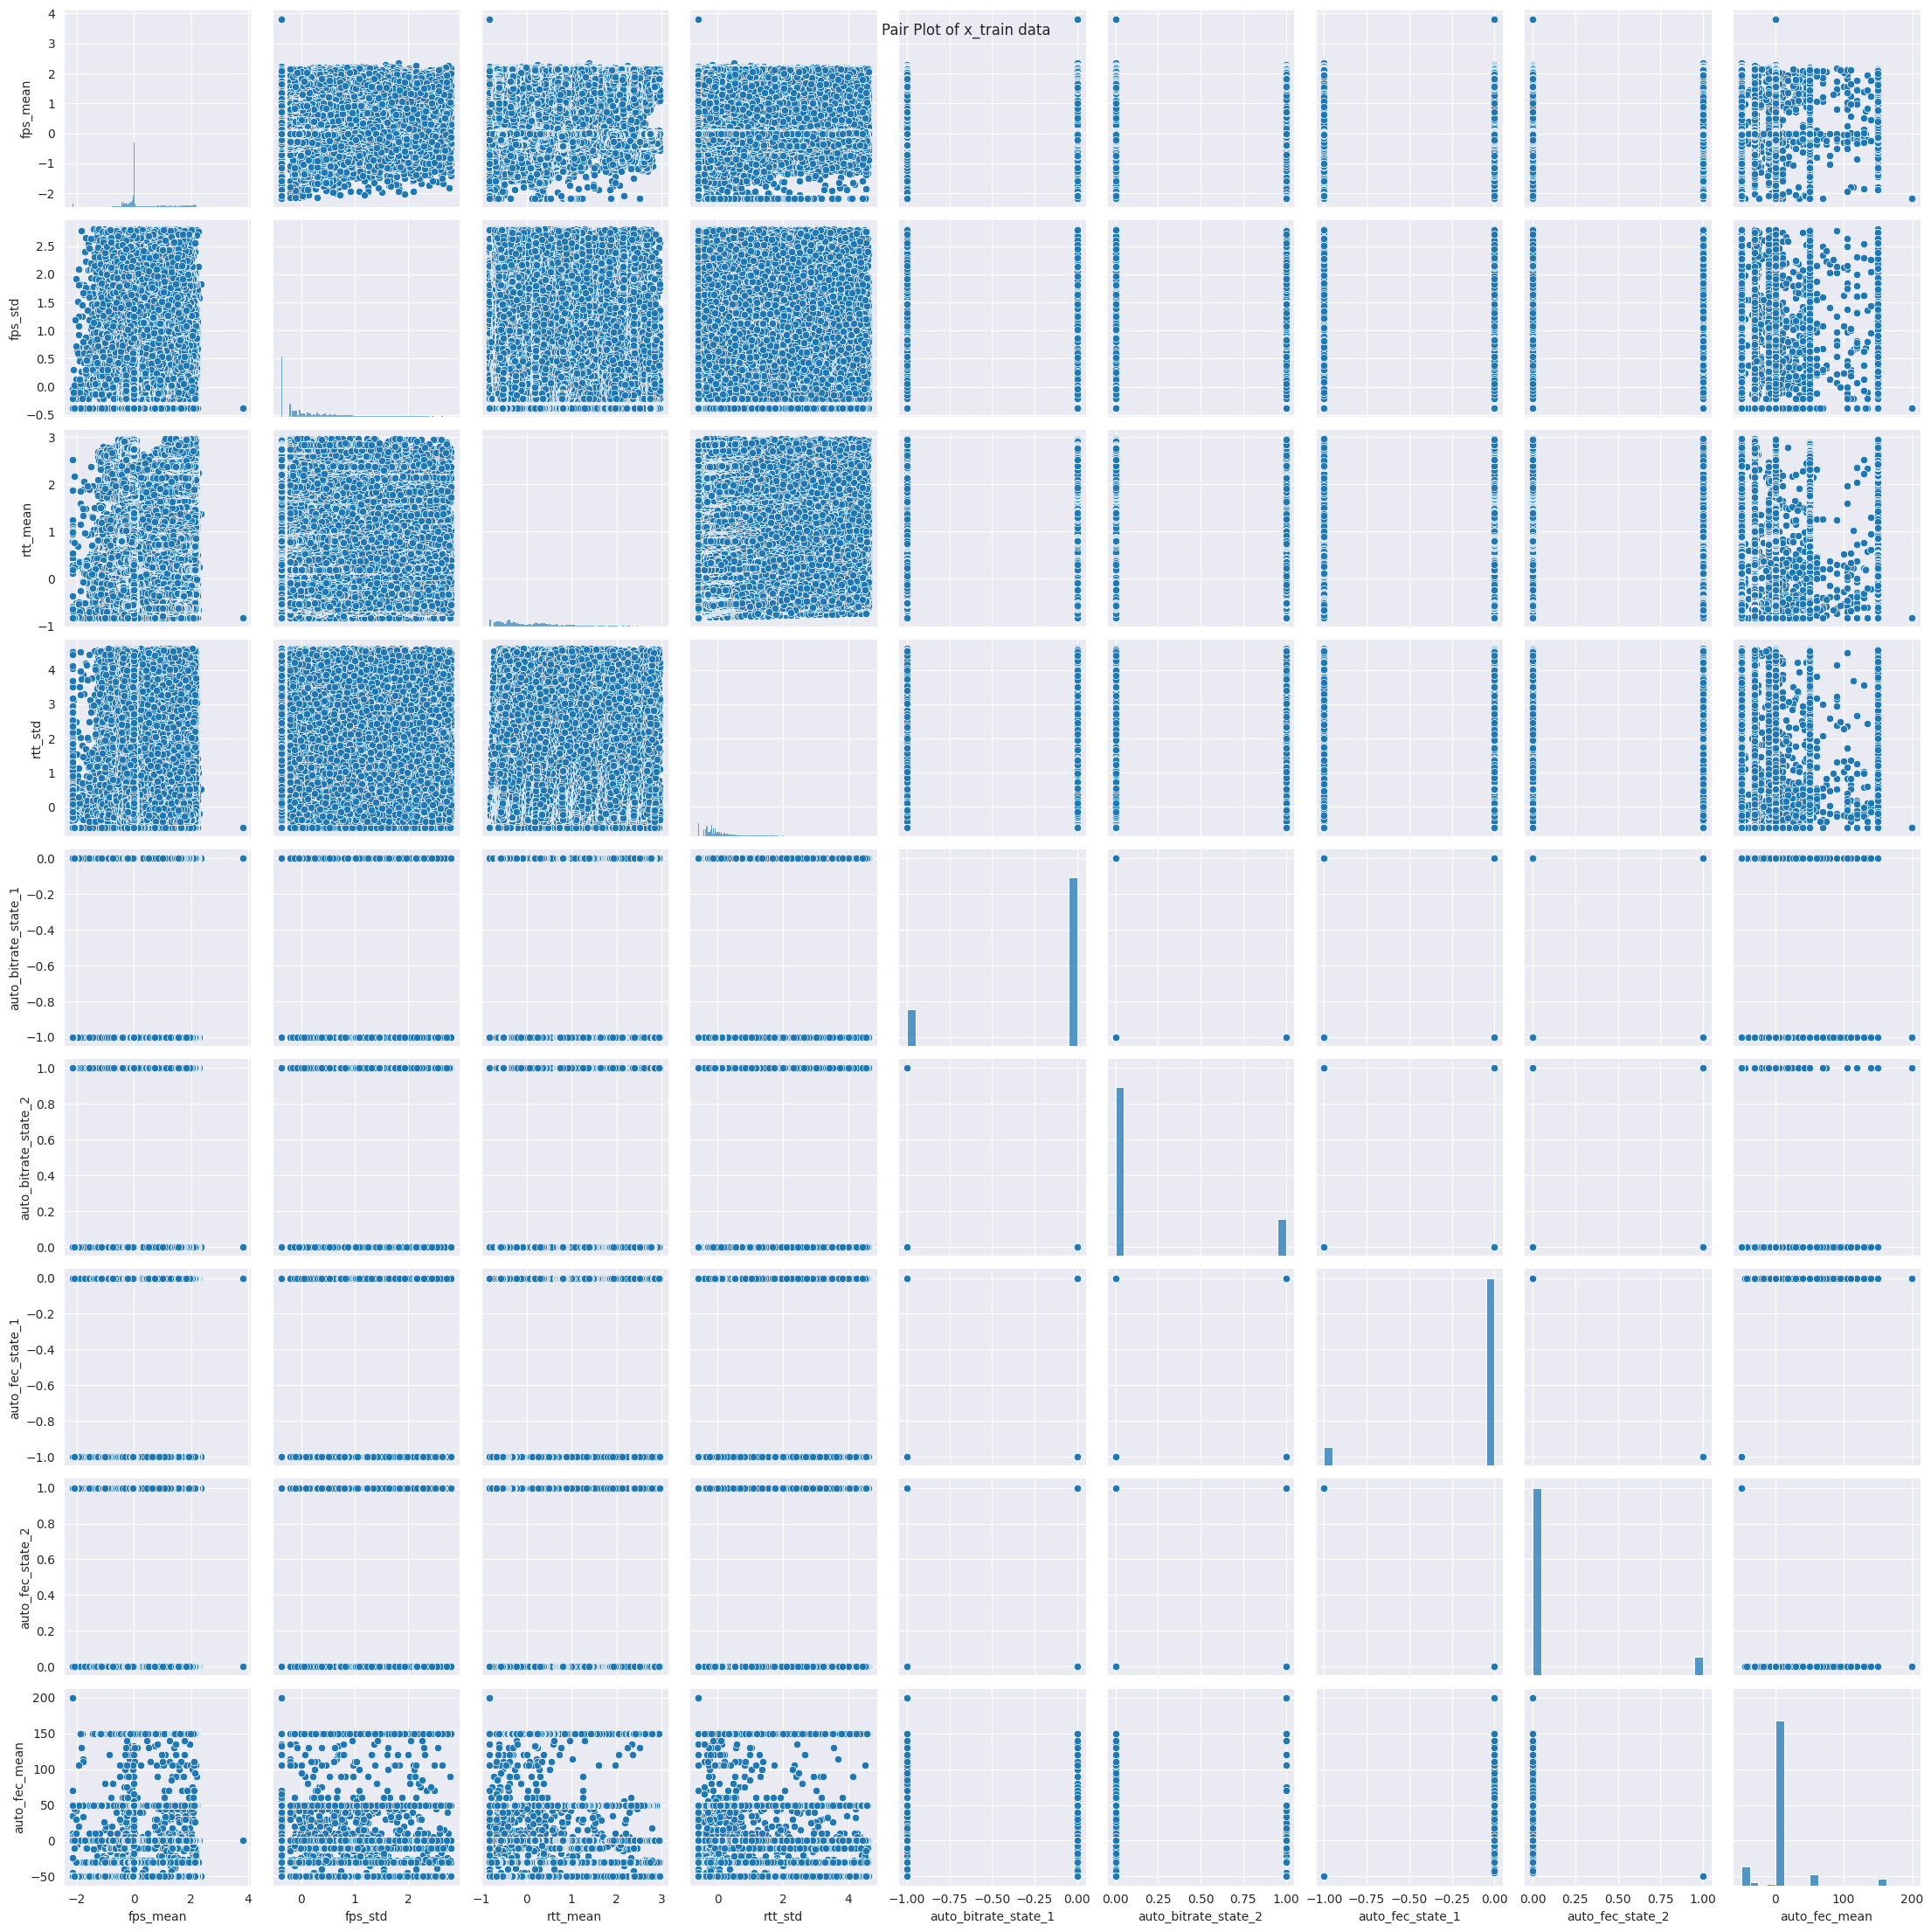

In [19]:
# Pair Plot of x_train after preprocessing of the data
# This takes latest 4 minutes to execute
pair_plot(x_train, suptitle_label="Pair Plot of x_train data")

#### 8. Creating Validation set from the Training set

In [20]:
# Split the x_train to two parts x_val and x_train
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=0)
y_train, y_val = train_test_split(y_train, test_size=0.2, random_state=0)
print(f"\nShape of x_train : {x_train.shape}\nShape of x_val : {x_val.shape}")
print(f"Shape of y_train : {y_train.shape}\nShape of y_val : {y_val.shape}")


Shape of x_train : (232465, 9)
Shape of x_val : (58117, 9)
Shape of y_train : (232465,)
Shape of y_val : (58117,)


#### 9. PCA Visualization of reduced x_train with y_train


Shape of x_train before PCA (232465, 9)


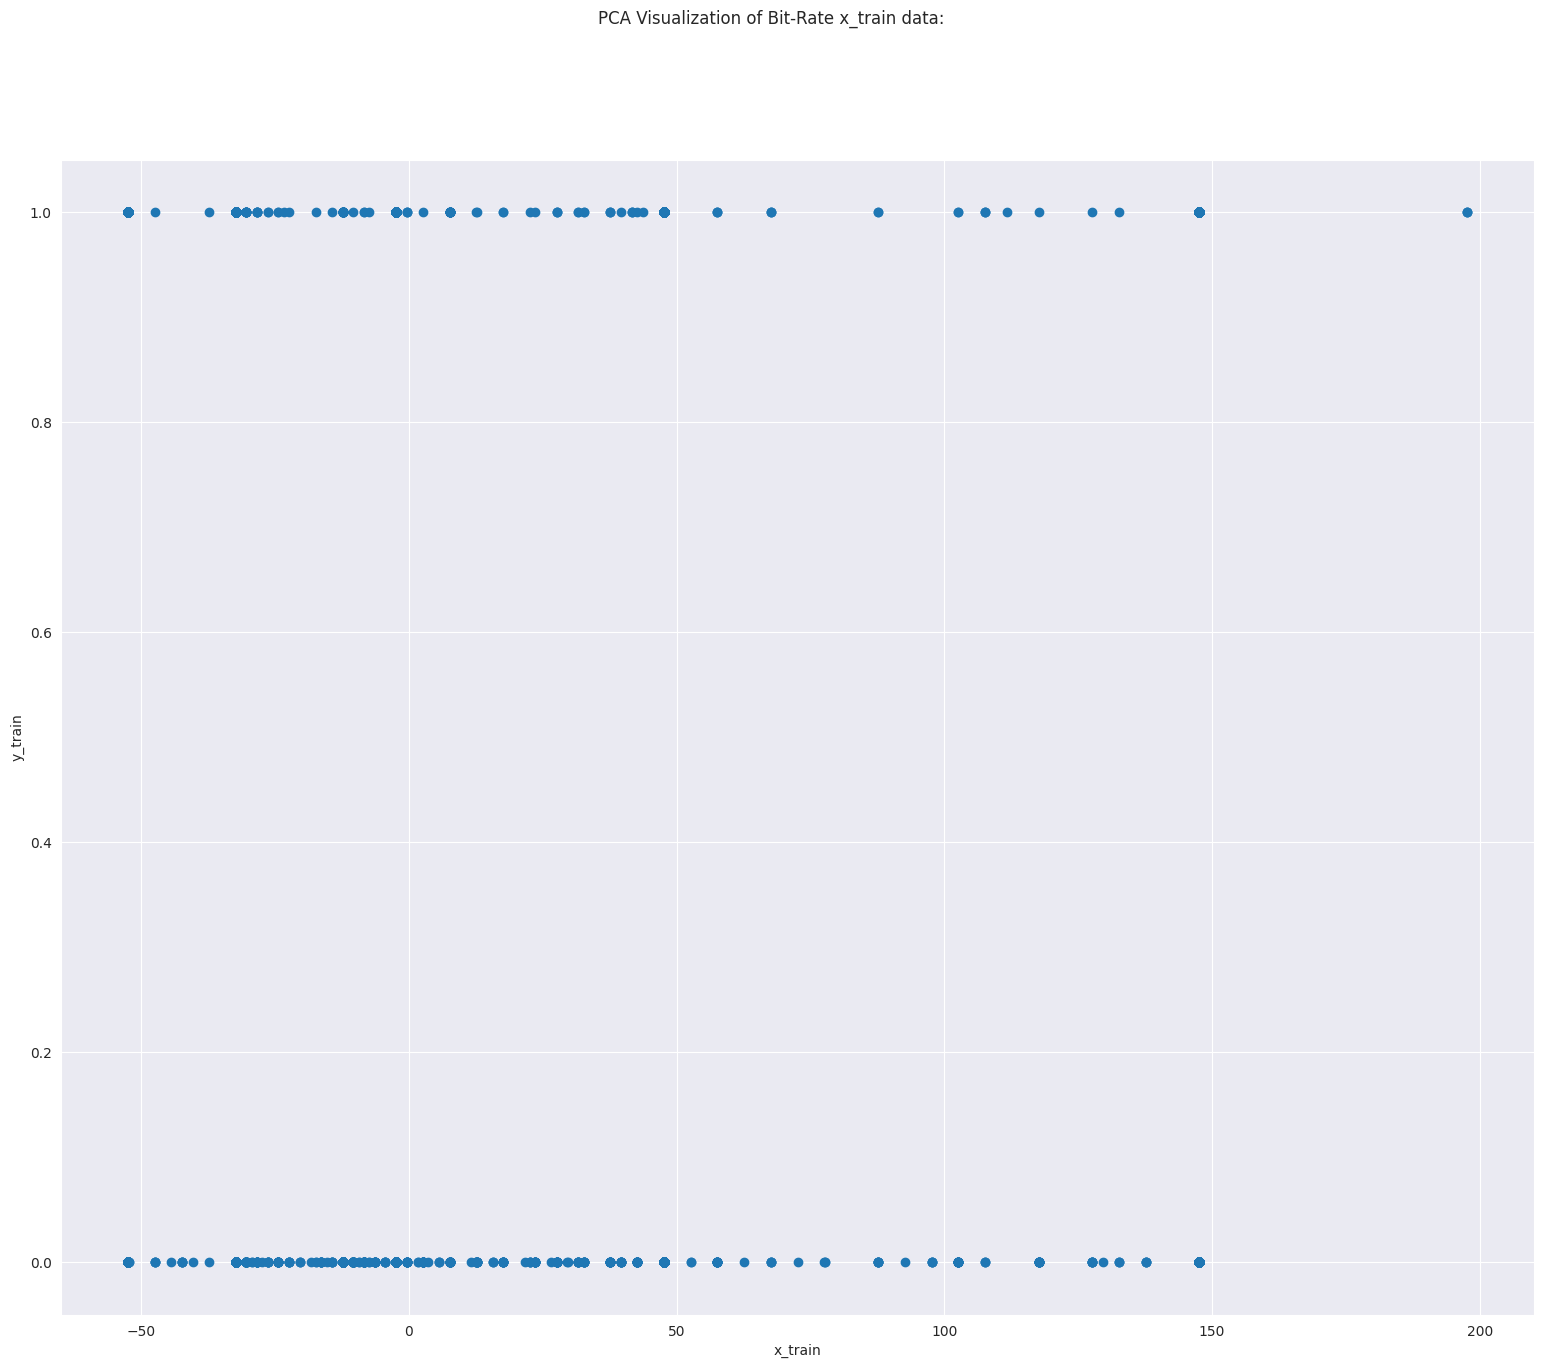


Shape of x_train after PCA (232465, 1)


In [21]:
# PCA Visualization of the Complete Dataframe x_train in 2dimensional graphs
print("\nShape of x_train before PCA", x_train.shape)
dimes_reducer = PCA(n_components=1)
x_train_reduced = dimes_reducer.fit_transform(x_train)
f = plt.figure(figsize=(19, 15))
plt.scatter(x_train_reduced[:, 0], y_train, marker='o')    # x_train_reduced[:, 1]
plt.suptitle("PCA Visualization of Bit-Rate x_train data: ")
plt.xlabel("x_train")
plt.ylabel("y_train")
plt.show()
print("\nShape of x_train after PCA", x_train_reduced.shape)

### 10. Logistic Regression with L2 Regularization

In [22]:
def print_metrics(y_true, y_predict):
    """Prints the Metrics such as Accuracy, Precision, Recall, F1 Score of the
    true and predicted values of a particular classifier model
    :param y_true: True target dataframe
    :param y_predict: Predicted target dataframe"""

    p, r, f1, _ = precision_recall_fscore_support(y_true, y_predict, average='macro')
    print("Accuracy, Precision, Recall and F1_score are: ")
    print("Precision : ", p)
    print("Recall : ", r)
    print("F1 score : ", f1)
    a = accuracy_score(y_true, y_predict)
    print("Accuracy : ", a)
    print("\nClassification Report:")
    target_names = [ 'Class 0', 'Class 1',]
    print(classification_report(y_true, y_predict, target_names=target_names))
    return None

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- auto_bitrate_state_3
Feature names seen at fit time, yet now missing:
- auto_bitrate_state_2

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- auto_bitrate_state_3
Feature names seen at fit time, yet now missing:
- auto_bitrate_state_2

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- auto_bitrate_state_3
Feature names seen at fit time, yet 


Performance Metrics of Logistic Regression with L2 Regularization:
Accuracy, Precision, Recall and F1_score are: 
Precision :  0.9532232663999389
Recall :  0.5179599349355474
F1 score :  0.5264140694685956
Accuracy :  0.9675449202823159

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98    171843
     Class 1       0.94      0.04      0.07      5972

    accuracy                           0.97    177815
   macro avg       0.95      0.52      0.53    177815
weighted avg       0.97      0.97      0.95    177815



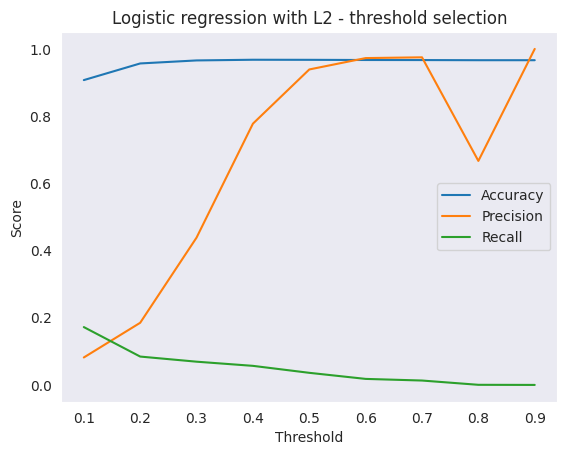

In [23]:
# Logistic Regression Model with L2 Regularization
logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500000, random_state=0).fit(x_train, y_train)

y_pred = logistic_model.predict(x_test)
y_pred_prob = logistic_model.predict_proba(x_test)

print("\nPerformance Metrics of Logistic Regression with L2 Regularization:")
print_metrics(y_true=y_test, y_predict=y_pred)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_pred_prob = logistic_model.predict_proba(x_test)
vals = [[], [], []]
for i in thresholds:
    y_test_pred_thr = np.where(y_pred_prob[:, 1] > i, 1, 0)
    vals[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))
    vals[1].append(metrics.precision_score(y_test, y_test_pred_thr, zero_division=1))
    vals[2].append(metrics.recall_score(y_test, y_test_pred_thr))

plt.plot(thresholds, vals[0], label='Accuracy')
plt.plot(thresholds, vals[1], label='Precision')
plt.plot(thresholds, vals[2], label='Recall')
plt.title('Logistic regression with L2 - threshold selection')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


### 11. Balancing - Logistic Regression with OverSampling

In [24]:
# Logistic Regression with Over sampling
o_sampler = RandomOverSampler(sampling_strategy=0.5)
x_over, y_over = o_sampler.fit_resample(x_train, y_train)
print("y_train count : \n", y_train.value_counts())
print("y_over count : \n", y_over.value_counts())

logistic_samp_model = LogisticRegression().fit(x_over.values, y_over)
pred_over = logistic_samp_model.predict(x_test)
print("\nPerformance Metrics of Logistic Regression with Over Sampling:")
print_metrics(y_true=y_test, y_predict=pred_over)

y_train count : 
 0    221288
1     11177
Name: stream_quality, dtype: int64
y_over count : 
 0    221288
1    110644
Name: stream_quality, dtype: int64

Performance Metrics of Logistic Regression with Over Sampling:
Accuracy, Precision, Recall and F1_score are: 
Precision :  0.5313621391724593
Recall :  0.5582936741441185
F1 score :  0.538014258279464
Accuracy :  0.9138261676461491

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.94      0.95    171843
     Class 1       0.09      0.18      0.12      5972

    accuracy                           0.91    177815
   macro avg       0.53      0.56      0.54    177815
weighted avg       0.94      0.91      0.93    177815



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### 12. Decision Tree Classifier

In [25]:
# DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier().fit(x_train, y_train)
y_pred_dt = decision_tree_model.predict(x_test)
print("\nPerformance Metrics of Decision Tree Classifier:")
print_metrics(y_true=y_test, y_predict=y_pred_dt)


Performance Metrics of Decision Tree Classifier:
Accuracy, Precision, Recall and F1_score are: 
Precision :  0.5267586859713795
Recall :  0.5482636696148748
F1 score :  0.531995093348782
Accuracy :  0.9144335404774625

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.94      0.96    171843
     Class 1       0.08      0.16      0.11      5972

    accuracy                           0.91    177815
   macro avg       0.53      0.55      0.53    177815
weighted avg       0.94      0.91      0.93    177815



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- auto_bitrate_state_3
Feature names seen at fit time, yet now missing:
- auto_bitrate_state_2

  warnings.warn(message, FutureWarning)


### 13. Support Vector Machine Classifier

In [26]:
# Support Vector Machine Classifier
# svm_model = SVC(kernel='linear')
#svm_model.fit(x_train, y_train)
#y_pred_svm = svm_model.predict(x_test)
#print("\nPerformance Metrics of Support Vector Machine Classifier")
#print_metrics(y_true=y_test, y_predict=y_pred_svm)